# Kickstarter Projects A.Kume
Day2で追加したこと<br>
  ①clossTabを用いて、分類系項目の傾向を確認<br>
  ②グラフ化後の考察を追加<br>
 ③傾向の見えなかった散布図行列出力処理をコメント化<br> 
Day3で追加したこと<br> 
　①ロジスティクス回帰にL2正則化を適用<br>
　②L1での特徴量選択実施したうえで、ロジスティクス回帰実行<br>
　③ランダムフォレスト実行<br>
　④ランダムフォレスト+グリッドサーチ<br>
　⑤SVM実行（Day2リベンジ）<br>
　⑥AdaBoost<br>
　⑦ニューラルネット<br>
　⑧各モデルの精度をDFで一元的に見やすく成形<br>
※dfについて<br>
 df_KS：取得データが基本<br> 
 df_KS_Dummy：カテゴリをダミー変数(0/1）に置き換えたもの

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import itertools
# import mglearn
import math
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from datetime import timedelta
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.linear_model import LassoCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation
from tensorflow.compat.v1.keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

# 1. データセットの確認

## 1.1 各項目の意味を確認
 
参考)
    https://www.kaggle.com/kemical/kickstarter-projects

| カラム名 | 英語 | 日本語 |
|:-|:-|:-|
| ID | internal kickstarter id | 時間 |
| name | name of project - A project is a finite work with a clear goal that you’d like to bring to life. Think albums, books, or | プロジェクト名 |
| category |  | カテゴリ |
| main_category | category of campaign | キャンペーン種類 |
| currency | currency used to support | 通貨 |
| deadline | deadline for crowdfunding | クラウドファンディング締切日→開始日～締切日の日数項目を追加する |
| goal | fundraising goal - The funding goal is the amount of money that a creator needs to complete their project. | 資金調達目標 - クリエイターがプロジェクトを完成させるために必要な金額 |
| launched | date launched | クラウドファンディング開始日 |
| pledged | amount pledged by "crowd" | 【終了後取得可能データ？】寄付額 |
| state | Current condition the project is in | 【目的変数】クラウドファンディング結果 |
| backers | number of backers | 【終了後取得可能データ？】賛同者数 |
| country | country pledged from | クラウドファンディング実施国 |
| usd pledged | Pledged amount in USD (conversion made by KS) | 【終了後取得可能データ？】寄付額米ドル換算 (KickStarter によるドル表示) |
| usd_pledged_real | Pledged amount in USD (conversion made by fixer.io api) | 【終了後取得可能データ？】寄付額米ドル換算 (fixer.io api によるドル表示) |
| usd_goal_real | Goal amount in USD　| 資金調達目標米ドル換算  (fixer.io api によるドル表示) |

## 1. 2.データの読み込み・目的変数数値化・不要項目削除、有意項目創出
データの読み込みと各項目の意味を踏まえて、目的変数の数値化、有意でないユニークキーと結果として得られる項目の削除、クラウドファンディング期間項目の創出
### ①データの中身を眺める
　目的変数が文字列。数値カテゴリ化が必要＆成功と失敗だけあればよい。<br>
　クラウドファンディング開始日、終了日はあるが、ファンディング期間はないので追加したい。

In [2]:
df_KS = pd.read_csv("4104_16930_bundle_archive/ks-projects-201801.csv")
df_KS.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


### ②目的変数数値化
　②-1目的変数のバリエーション確認

In [3]:
print(list(df_KS.state.unique()))

['failed', 'canceled', 'successful', 'live', 'undefined', 'suspended']


　②-2目的変数のバリエーションを踏まえて、目的変数の値のうち、'canceled', 'live', 'undefined', 'suspended'は結果が出てないデータなので削除
 
　②-3目的変数のバリエーションを踏まえて、目的変数を、ダミー変数へ-successfulを1、その他を0へ。ダミー変数化した目的変数を先頭列へ

In [4]:
# 目的変数の値のうち、liveは結果が出てないデータなので削除
df_KS = df_KS.query('state != ["canceled", "live", "undefined", "suspended"]')

# 目的変数を、ダミー変数へ-successfulを1、その他を0へ。
#df_KS = df_KS.insert('0','state_successful',(df_KS['state'] == 'successful').astype(int))
df_KS = df_KS.assign(state_successful=(df_KS['state'] == 'successful').astype(int))
cols = df_KS.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_KS = df_KS[cols]

### ③項目説明の情報を基に、単なるユニークキーと、結果として得られる項目を削除
　ID：ただのユニークキーなので削除<br>
　'pledged', 'backers', 'usd pledged','usd_pledged_real':クラウドファンディング結果として得られる項目のなので削除<br>
　state:ダミー変数化した別項目あるので削除

In [5]:
# 項目説明より、有意でない一意な値を持つID列と、終了後取得されるデータ列を削除
df_KS = df_KS.drop(['ID', 'pledged', 'backers', 'usd pledged','usd_pledged_real','state'],axis=1).copy(deep=True) 

### ④日付文字列の日付型化と、クラウドファンディング日数項目創出
　募集期間に意味があるのではないかと考え、クラウドファンディング期間項目を追加

In [6]:
# 日付文字列を基に、日付型に変換。各日付を年、月、日に数値型に変換格納
df_KS['deadline'] = pd.to_datetime(df_KS['deadline'])
df_KS['launched'] = pd.to_datetime(df_KS['launched'])
df_KS['deadline_Year'] = df_KS['deadline'].apply(lambda x:x.year)
df_KS['deadline_Month'] = df_KS['deadline'].apply(lambda x:x.month)
df_KS['deadline_Day'] = df_KS['deadline'].apply(lambda x:x.day)
df_KS['launched_Year'] = df_KS['launched'].apply(lambda x:x.year)
df_KS['launched_Month'] = df_KS['launched'].apply(lambda x:x.month)
df_KS['launched_Day'] = df_KS['launched'].apply(lambda x:x.day)
# クラウドファンディング日数列追加
df_KS['KS_Days'] = (df_KS['deadline'] - df_KS['launched']) / timedelta(days=1)

## 1. 3.ClossTabを用いて、分類系項目の傾向を確認(Day2で追加)
### category,main_categoryを用いてClossTab出力。
　①categoryを集約したものがmainCategoryであると裏付けられる<br>
　②categoryにより、成功率にばらつきがみられる。その傾向をmainCategoryがある程度踏襲しているも、完全ではない<br>
　③categoryの種類が非常に多い。main_categoryは15種類程度<br>
　④両項目とも、欠損値はない 
### →categoryを削除し、main_categoryに集約とする

In [7]:
pd.crosstab([df_KS['category'], df_KS['state_successful']], [df_KS['main_category']],margins=True)

main_category                          Art  Comics  Crafts  Dance  Design  \
category           state_successful                                         
3D Printing        0                     0       0       0      0       0   
                   1                     0       0       0      0       0   
Academic           0                     0       0       0      0       0   
                   1                     0       0       0      0       0   
Accessories        0                     0       0       0      0       0   
                   1                     0       0       0      0       0   
Action             0                     0       0       0      0       0   
                   1                     0       0       0      0       0   
Animals            0                     0       0       0      0       0   
                   1                     0       0       0      0       0   
Animation          0                     0       0       0      0       0   
                   1                     0       0       0      0       0   
Anthologies        0                     0      83       0      0       0   
                   1                     0     303       0      0       0   
Apparel            0                     0       0       0      0       0   
                   1                     0       0       0      0       0   
Apps               0                     0       0       0      0       0   
                   1                     0       0       0      0       0   
Architecture       0                     0       0       0      0     463   
                   1                     0       0       0      0     179   
Art                0                  4101       0       0      0       0   
                   1                  3385       0       0      0       0   
Art Books          0                     0       0       0      0       0   
                   1                     0       0       0      0       0   
Audio              0                     0       0       0      0       0   
                   1                     0       0       0      0       0   
Bacon              0                     0       0       0      0       0   
                   1                     0       0       0      0       0   
Blues              0                     0       0       0      0       0   
                   1                     0       0       0      0       0   
Calendars          0                     0       0       0      0       0   
                   1                     0       0       0      0       0   
Camera Equipment   0                     0       0       0      0       0   
                   1                     0       0       0      0       0   
Candles            0                     0       0     323      0       0   
                   1                     0       0      55      0       0   
Ceramics           0                   143       0       0      0       0   
                   1                   132       0       0      0       0   
Children's Books   0                     0       0       0      0       0   
                   1                     0       0       0      0       0   
Childrenswear      0                     0       0       0      0       0   
                   1                     0       0       0      0       0   
Chiptune           0                     0       0       0      0       0   
                   1                     0       0       0      0       0   
Civic Design       0                     0       0       0      0     162   
                   1                     0       0       0      0     104   
Classical Music    0                     0       0       0      0       0   
                   1                     0       0       0      0       0   
Comedy             0                     0       0       0      0       0   
                   1                     0       0       0      0       0

In [8]:
pd.crosstab([df_KS['category']], [df_KS['state_successful']],margins=True)

state_successful,0,1,All
category,,,
3D Printing,326,242,568
Academic,589,188,777
Accessories,1667,1073,2740
Action,514,107,621
Animals,166,63,229
Animation,1531,682,2213
Anthologies,216,521,737
Apparel,4752,1414,6166
Apps,4909,378,5287


In [9]:
pd.crosstab([df_KS['main_category']], [df_KS['state_successful']],margins=True)

state_successful,0,1,All
main_category,,,
Art,14131,11510,25641
Comics,4036,5842,9878
Crafts,5703,2115,7818
Dance,1235,2338,3573
Design,14814,10550,25364
Fashion,14182,5593,19775
Film & Video,32904,23623,56527
Food,15969,6085,22054
Games,16003,12518,28521


### currency,state_successful,countryを用いてClossTab出力。
①country側N,0と欠損値っぽいものがあるが、Currency側は各国通貨にきちんとなっている<br>
②ヨーロッパに関しては、countryは各国だが、Currencyはユーロに集約されている。他国はcountryとCurrencyが一対一<br>
③ヨーロッパを見てみると、countryにより成功・失敗に若干の散らばりがあり。<br>
④countryは、currencyに比べるともヨーロッパの集約分一桁のカテゴリ増加があるのみ
### →currencyを削除し、countryに集約。EURとして、N,0となっている21件に関しては、EURで一番件数の多いDEとする。他は１対１で対応する国名へ設定

In [10]:
pd.crosstab([df_KS['currency'], df_KS['state_successful']], [df_KS['country']],margins=True)

country                     AT    AU   BE     CA   CH    DE   DK    ES    FR  \
currency state_successful                                                      
AUD      0                   0  4606    0      0    0     0    0     0     0   
         1                   0  2010    0      0    0     0    0     0     0   
CAD      0                   0     0    0   8236    0     0    0     0     0   
         1                   0     0    0   4134    0     0    0     0     0   
CHF      0                   0     0    0      0  465     0    0     0     0   
         1                   0     0    0      0  187     0    0     0     0   
DKK      0                   0     0    0      0    0     0  566     0     0   
         1                   0     0    0      0    0     0  360     0     0   
EUR      0                 378     0  371      0    0  2499    0  1381  1612   
         1                 107     0  152      0    0   937    0   492   908   
GBP      0                   0     0    0      0    0     0    0     0     0   
         1                   0     0    0      0    0     0    0     0     0   
HKD      0                   0     0    0      0    0     0    0     0     0   
         1                   0     0    0      0    0     0    0     0     0   
JPY      0                   0     0    0      0    0     0    0     0     0   
         1                   0     0    0      0    0     0    0     0     0   
MXN      0                   0     0    0      0    0     0    0     0     0   
         1                   0     0    0      0    0     0    0     0     0   
NOK      0                   0     0    0      0    0     0    0     0     0   
         1                   0     0    0      0    0     0    0     0     0   
NZD      0                   0     0    0      0    0     0    0     0     0   
         1                   0     0    0      0    0     0    0     0     0   
SEK      0                   0     0    0      0    0     0    0     0     0   
         1                   0     0    0      0    0     0    0     0     0   
SGD      0                   0     0    0      0    0     0    0     0     0   
         1                   0     0    0      0    0     0    0     0     0   
USD      0                   0     0    0      0    0     0    0     0     0   
         1                   0     0    0      0    0     0    0     0     0   
All                        485  6616  523  12370  652  3436  926  1873  2520   

country                       GB   HK   IE    IT  JP  LU    MX  N,0"    NL  \
currency state_successful                                                    
AUD      0                     0    0    0     0   0   0     0     4     0   
         1                     0    0    0     0   0   0     0     1     0   
CAD      0                     0    0    0     0   0   0     0     2     0   
         1                     0    0    0     0   0   0     0     3     0   
CHF      0                     0    0    0     0   0   0     0     0     0   
         1                     0    0    0     0   0   0     0     0     0   
DKK      0                     0    0    0     0   0   0     0     1     0   
         1                     0    0    0     0   0   0     0     2     0   
EUR      0                     0    0  476  1930   0  38     0    17  1794   
         1                     0    0  207   439   0  19     0     4   617   
GBP      0                 17387    0    0     0   0   0     0     8     0   
         1                 12067    0    0     0   0   0     0    14     0   
HKD      0                     0  261    0     0   0   0     0     0     0   
         1                     0  216    0     0   0   0     0     0     0   
JPY      0                     0    0    0     0  16   0     0     0     0   
         1                     0    0    0     0   7   0     0     0     0   
MXN      0                     0    0    0     0   0   0  1015     0     0   
         1                     0    0

In [11]:
df_KS.loc[(df_KS.country == 'N,0"') & (df_KS.currency == 'AUD'),'country'] = 'AU'
df_KS.loc[(df_KS.country == 'N,0"') & (df_KS.currency == 'CAD'),'country'] = 'CA'
df_KS.loc[(df_KS.country == 'N,0"') & (df_KS.currency == 'DKK'),'country'] = 'DK'
df_KS.loc[(df_KS.country == 'N,0"') & (df_KS.currency == 'EUR'),'country'] = 'DE'
df_KS.loc[(df_KS.country == 'N,0"') & (df_KS.currency == 'GBP'),'country'] = 'GB'
df_KS.loc[(df_KS.country == 'N,0"') & (df_KS.currency == 'NOK'),'country'] = 'NO'
df_KS.loc[(df_KS.country == 'N,0"') & (df_KS.currency == 'SEK'),'country'] = 'SE'
df_KS.loc[(df_KS.country == 'N,0"') & (df_KS.currency == 'USD'),'country'] = 'US'

## 1. 4.相関値確認
①goalとusd_goal_realは強い相関。説明を見る限り、どちらも意味合いは同じ項目であり、それが裏付けられた<br>
②目的変数state_DMYとの相関がある項目が現状では見当たらない。<br>
③nameに欠損値あるも、利用予定のない項目なので無視
### →goalを削除し、usd_goal_realに集約。

In [12]:
df_KS.describe()

,state_successful,goal,usd_goal_real,deadline_Year,deadline_Month,deadline_Day,launched_Year,launched_Month,launched_Day,KS_Days
count,331675.000000,3.316750e+05,3.316750e+05,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000
mean,0.403877,4.425157e+04,4.151000e+04,2014.244522,6.758483,15.271474,2014.180002,6.416163,15.285361,33.389378
std,0.490674,1.117917e+06,1.108930e+06,1.919265,3.315202,9.038884,1.930922,3.306989,8.814445,12.723385
min,0.000000,1.000000e-02,1.000000e-02,2009.000000,1.000000,1.000000,2009.000000,1.000000,1.000000,0.005058
25%,0.000000,2.000000e+03,2.000000e+03,2013.000000,4.000000,7.000000,2013.000000,4.000000,8.000000,29.088929
50%,0.000000,5.000000e+03,5.000000e+03,2014.000000,7.000000,15.000000,2014.000000,6.000000,15.000000,29.656759
75%,1.000000,1.500000e+04,1.500000e+04,2016.000000,10.000000,23.000000,2016.000000,9.000000,23.000000,35.705966
max,1.000000,1.000000e+08,1.663614e+08,2018.000000,12.000000,31.000000,2017.000000,12.000000,31.000000,91.962650


## 1. 5.上記で決定した項目の削除

In [13]:
df_KS = df_KS.drop(['name', 'category', 'currency','goal'],axis=1).copy(deep=True) 

## 1. 6.グラフ化
各項目の分布をみるために、グラフ化。思ったことは以下<br>
　①main_categoryはMusicの成功率は高く、Technologyは失敗が多いなど、関係がありそう<br>
　②currency(通貨)、country(国)は、USが多い<br>
　③goal（目標額）が少額だと、成功していそう

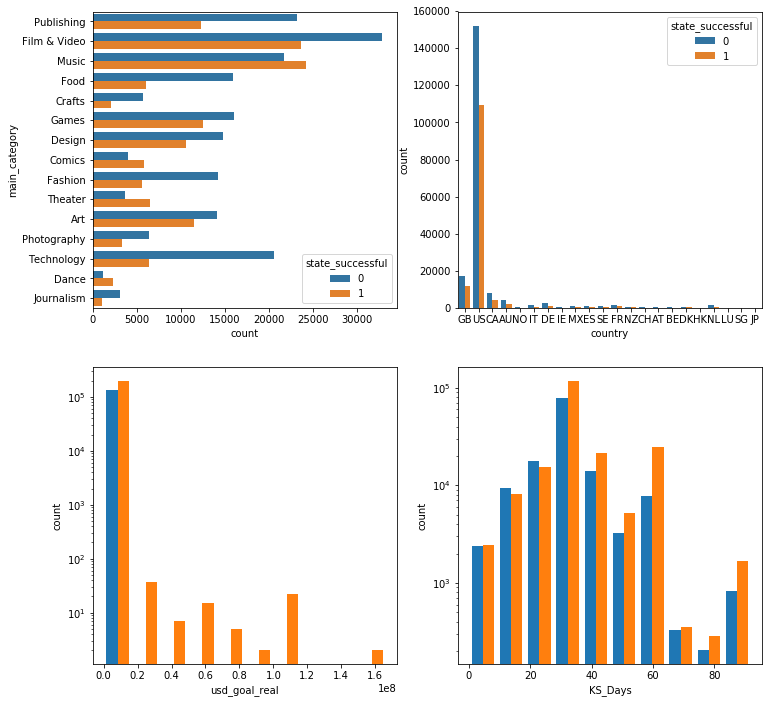

In [14]:
fig,ax = plt.subplots(2,2,figsize=(12,12))
sns.countplot(y="main_category", hue="state_successful", data=df_KS, ax=ax[0][0])
sns.countplot(x = 'country', hue="state_successful", data=df_KS, ax=ax[0][1])
ax[1][0].hist([df_KS[df_KS['state_successful'] == True].usd_goal_real,df_KS[df_KS['state_successful'] == False].usd_goal_real], label=['Successful','failed'],log=True)
ax[1][0].set_xlabel('usd_goal_real')
ax[1][0].set_ylabel('count')
ax[1][1].hist([df_KS[df_KS['state_successful'] == True].KS_Days,df_KS[df_KS['state_successful'] == False].KS_Days], label='KS_Days',log=True)
ax[1][1].set_xlabel('KS_Days')
ax[1][1].set_ylabel('count')
plt.show()

# 2. 標準化、特徴両選択、ロジスティック回帰実施と評価

## 2.1 objectのダミー変数化

In [15]:
# ダミー変数化
df_KS_Dummy = pd.get_dummies(df_KS, columns = ['country','main_category'])

## 2.2 ロジスティクス回帰実行(特徴量選択前&L2正則化)

In [16]:
y_data = df_KS_Dummy["state_successful"]
y = y_data.values
# 目的変数、Dummy変数化した説明変数を削除
X_data = df_KS_Dummy.drop(["state_successful","deadline","launched"],axis=1)
X = X_data.values

In [17]:
n_split = 5 # グループ数を設定（今回は5分割）

df_cross_valid_log_day2 = pd.DataFrame(index=range(n_split), 
                                    columns=['test_accuracy', 'test_precistion', 'test_recall', 'test_f1', 
                                             'train_accuracy', 'train_precistion', 'train_recall', 'train_f1'])
df_model_performance = pd.DataFrame(index=range(10), 
                                    columns=['model_name', 'test_accuracy', 'test_precistion', 'test_recall', 'test_f1', 
                                             'train_accuracy', 'train_precistion', 'train_recall', 'train_f1'])
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
    #説明変数の標準化
    stdsc = StandardScaler()
    X_train_stand = stdsc.fit_transform(X_train)
    X_test_stand = stdsc.transform(X_test)
    
    # 学習用データを使ってロジスティクス回帰を学習
    clf = SGDClassifier(loss='log', penalty='l2', n_jobs=-1, max_iter=20000, fit_intercept=True, random_state=1234, tol=1e-8)
    clf.fit(X_train_stand, y_train)

    # 汎化誤差算出のため、テストデータに対する予測を実行
    y_pred_test = clf.predict(X_test_stand)

    # 汎化誤差Precision, Recall, F1-scoreを計算
    precision_test, recall_test, f1_score_test, _ = precision_recall_fscore_support(y_test, y_pred_test)

    # 訓練誤差算出のため、トレーニングデータに対する予測を実行
    y_pred_train = clf.predict(X_train_stand)

    # 訓練誤差Precision, Recall, F1-scoreを計算
    precision_train, recall_train, f1_score_train, _ = precision_recall_fscore_support(y_train, y_pred_train)

    df_cross_valid_log_day2.at[(split_num - 1),"test_accuracy"] = accuracy_score(y_test,y_pred_test) * 100
    df_cross_valid_log_day2.at[(split_num - 1),"test_precistion"] = precision_test[0] * 100
    df_cross_valid_log_day2.at[(split_num - 1),"test_recall"] = recall_test[0] * 100
    df_cross_valid_log_day2.at[(split_num - 1),"test_f1"] = f1_score_test[0] * 100
    df_cross_valid_log_day2.at[(split_num - 1),"train_accuracy"] = accuracy_score(y_train,y_pred_train) * 100
    df_cross_valid_log_day2.at[(split_num - 1),"train_precistion"] = precision_train[0] * 100
    df_cross_valid_log_day2.at[(split_num - 1),"train_recall"] = recall_train[0] * 100
    df_cross_valid_log_day2.at[(split_num - 1),"train_f1"] = f1_score_train[0] * 100

    print("*** Cross Validation Score split_num={0} ***".format(split_num))
    # 予測値と正解のクロス集計
    conf_mat = pd.DataFrame(confusion_matrix(y_test,y_pred_test),
               index = ['正解：state_successful','正解：state_faild'],
               columns=['予測：state_successful','予測：state_faild'])
    print(conf_mat)
    split_num += 1

*** Cross Validation Score split_num=1 ***
                     予測：state_successful  予測：state_faild
正解：state_successful                31438            8290
正解：state_faild                     15417           11190
*** Cross Validation Score split_num=2 ***
                     予測：state_successful  予測：state_faild
正解：state_successful                32176            7283
正解：state_faild                     16614           10262
*** Cross Validation Score split_num=3 ***
                     予測：state_successful  予測：state_faild
正解：state_successful                33276            6173
正解：state_faild                     17472            9414
*** Cross Validation Score split_num=4 ***
                     予測：state_successful  予測：state_faild
正解：state_successful                33452            6089
正解：state_faild                     17910            8884
*** Cross Validation Score split_num=5 ***
                     予測：state_successful  予測：state_faild
正解：state_successful                32503    

In [18]:
# クロスバリデーション各回の精度
df_cross_valid_log_day2

,test_accuracy,test_precistion,test_recall,test_f1,train_accuracy,train_precistion,train_recall,train_f1
0,64.2617,67.0964,79.1331,72.6193,64.0556,66.6931,79.171,72.3984
1,63.9753,65.9479,81.5429,72.9209,64.2033,66.2558,81.4817,73.0842
2,64.3552,65.5711,84.3519,73.7852,64.1924,65.5236,84.3514,73.7549
3,63.8215,65.1299,84.6008,73.5993,63.9334,65.211,84.6685,73.6767
4,64.218,66.063,82.1987,73.2528,64.1848,66.0611,82.0985,73.2119


In [19]:
# 本モデルでの精度
df_model_performance.at[0,"model_name"] = 'Day1 logistic精度'
df_model_performance.at[0,"test_accuracy"] = 52.483
df_model_performance.at[0,"test_precistion"] = 76.339
df_model_performance.at[0,"test_recall"] = 29.404
df_model_performance.at[0,"test_f1"] = 42.456

df_model_performance.at[1,"model_name"] = 'Day2 logistic精度'
df_model_performance.at[1,"test_accuracy"] = 64.698
df_model_performance.at[1,"test_precistion"] = 67.246
df_model_performance.at[1,"test_recall"] = 79.537
df_model_performance.at[1,"test_f1"] = 72.865

df_model_performance.at[2,"model_name"] = 'logistic(特徴量選択前&L2正則化)'
df_model_performance.at[2,"train_accuracy"] = df_cross_valid_log_day2[1:6]['train_accuracy'].mean()
df_model_performance.at[2,"train_precistion"] = df_cross_valid_log_day2[1:6]['train_precistion'].mean()
df_model_performance.at[2,"train_recall"] = df_cross_valid_log_day2[1:6]['train_recall'].mean()
df_model_performance.at[2,"train_f1"] = df_cross_valid_log_day2[1:6]['train_f1'].mean()
df_model_performance.at[2,"test_accuracy"] = df_cross_valid_log_day2[1:6]['test_accuracy'].mean()
df_model_performance.at[2,"test_precistion"] = df_cross_valid_log_day2[1:6]['test_precistion'].mean()
df_model_performance.at[2,"test_recall"] = df_cross_valid_log_day2[1:6]['test_recall'].mean()
df_model_performance.at[2,"test_f1"] = df_cross_valid_log_day2[1:6]['test_f1'].mean()

## 2.3 ロジスティクス回帰(特徴量選択前&L2正則化)のDay1,Day2時モデル精度との比較
### →Precisionは2%程度低下。他の指標は数%改善。

In [20]:
df_model_performance

,model_name,test_accuracy,test_precistion,test_recall,test_f1,train_accuracy,train_precistion,train_recall,train_f1
0,Day1 logistic精度,52.483,76.339,29.404,42.456,NaN,NaN,NaN,NaN
1,Day2 logistic精度,64.698,67.246,79.537,72.865,NaN,NaN,NaN,NaN
2,logistic(特徴量選択前&L2正則化),64.0925,65.678,83.1736,73.3896,64.1285,65.7629,83.1501,73.4319
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2.4.特徴量選択

In [21]:
# estimatorにモデルをセット
# LassoCVを使って、正則化の強さは自動決定
estimator = LassoCV(normalize=True, n_jobs=-1, cv=10, tol=1e-10)

# モデルの情報を使って特徴選択を行う場合は、SelectFromModelを使う
# 今回は係数が1e-8以下である特徴を削除する
# 係数のしきい値はthresholdで指定する
sfm = SelectFromModel(estimator, threshold=1e-8)

# fitで特徴選択を実行
sfm.fit(X, y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=-1, normalize=True, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=1e-10,
    verbose=False),
        max_features=None, norm_order=1, prefit=False, threshold=1e-08)

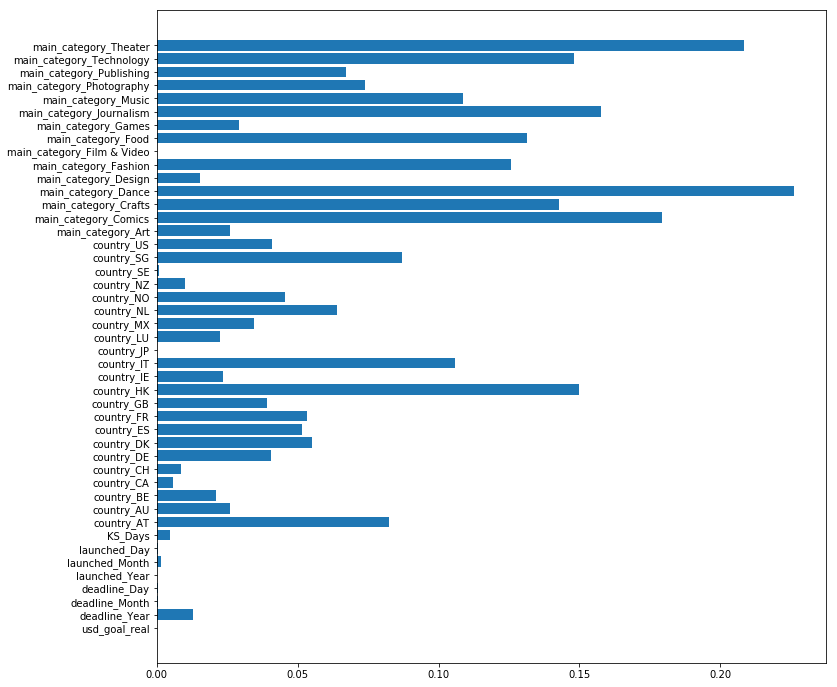

In [22]:
# LASSOで得た各特徴の係数の値を確認してみよう
# 係数の絶対値を取得
abs_coef = np.abs(sfm.estimator_.coef_)
# 係数を棒グラフで表示
plt.figure(figsize=(12,12))
plt.barh(np.arange(0, len(abs_coef)), abs_coef, tick_label=X_data.columns.values)
plt.show()

In [23]:
# 削除すべき特徴を削除 
removed_idx  = ~sfm.get_support()
remove_feature = X_data.columns[removed_idx]
X_Lasso_data = X_data.drop(remove_feature,axis=1)
X_Lasso = X_Lasso_data.values

# 2.5. ロジスティック回帰実施と評価(特徴量選択後&L2)

In [24]:
n_split = 5 # グループ数を設定（今回は5分割）

df_cross_valid_log_day3 = pd.DataFrame(index=range(n_split - 1), 
                                    columns=['test_accuracy', 'test_precistion', 'test_recall', 'test_f1', 
                                             'train_accuracy', 'train_precistion', 'train_recall', 'train_f1'])
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X_Lasso, y):
    X_train, y_train = X_Lasso[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X_Lasso[test_idx], y[test_idx]     #テスト用データ
    
    #説明変数の標準化
    stdsc = StandardScaler()
    X_train_stand = stdsc.fit_transform(X_train)
    X_test_stand = stdsc.transform(X_test)
    
    # 学習用データを使ってロジスティクス回帰を学習
    clf = SGDClassifier(loss='log', penalty='l2', n_jobs=-1, max_iter=20000, fit_intercept=True, random_state=1234, tol=1e-8)
    clf.fit(X_train_stand, y_train)

    # 汎化誤差算出のため、テストデータに対する予測を実行
    y_pred_test = clf.predict(X_test_stand)

    # 汎化誤差Precision, Recall, F1-scoreを計算
    precision_test, recall_test, f1_score_test, _ = precision_recall_fscore_support(y_test, y_pred_test)

    # 訓練誤差算出のため、トレーニングデータに対する予測を実行
    y_pred_train = clf.predict(X_train_stand)

    # 訓練誤差Precision, Recall, F1-scoreを計算
    precision_train, recall_train, f1_score_train, _ = precision_recall_fscore_support(y_train, y_pred_train)

    df_cross_valid_log_day3.at[(split_num - 1),"test_accuracy"] = accuracy_score(y_test,y_pred_test) * 100
    df_cross_valid_log_day3.at[(split_num - 1),"test_precistion"] = precision_test[0] * 100
    df_cross_valid_log_day3.at[(split_num - 1),"test_recall"] = recall_test[0] * 100
    df_cross_valid_log_day3.at[(split_num - 1),"test_f1"] = f1_score_test[0] * 100
    df_cross_valid_log_day3.at[(split_num - 1),"train_accuracy"] = accuracy_score(y_train,y_pred_train) * 100
    df_cross_valid_log_day3.at[(split_num - 1),"train_precistion"] = precision_train[0] * 100
    df_cross_valid_log_day3.at[(split_num - 1),"train_recall"] = recall_train[0] * 100
    df_cross_valid_log_day3.at[(split_num - 1),"train_f1"] = f1_score_train[0] * 100

    print("*** Cross Validation Score split_num={0} ***".format(split_num))
    # 予測値と正解のクロス集計
    conf_mat = pd.DataFrame(confusion_matrix(y_test,y_pred_test),
               index = ['正解：state_successful','正解：state_faild'],
               columns=['予測：state_successful','予測：state_faild'])
    print(conf_mat)
    split_num += 1

*** Cross Validation Score split_num=1 ***
                     予測：state_successful  予測：state_faild
正解：state_successful                32693            7035
正解：state_faild                     17223            9384
*** Cross Validation Score split_num=2 ***
                     予測：state_successful  予測：state_faild
正解：state_successful                32852            6607
正解：state_faild                     17781            9095
*** Cross Validation Score split_num=3 ***
                     予測：state_successful  予測：state_faild
正解：state_successful                33592            5857
正解：state_faild                     18333            8553
*** Cross Validation Score split_num=4 ***
                     予測：state_successful  予測：state_faild
正解：state_successful                33702            5839
正解：state_faild                     18803            7991
*** Cross Validation Score split_num=5 ***
                     予測：state_successful  予測：state_faild
正解：state_successful                33204    

In [25]:
df_model_performance.at[3,"model_name"] = 'logistic(特徴量選択後&L2正則化)'
df_model_performance.at[3,"train_accuracy"] = df_cross_valid_log_day3[1:6]['train_accuracy'].mean()
df_model_performance.at[3,"train_precistion"] = df_cross_valid_log_day3[1:6]['train_precistion'].mean()
df_model_performance.at[3,"train_recall"] = df_cross_valid_log_day3[1:6]['train_recall'].mean()
df_model_performance.at[3,"train_f1"] = df_cross_valid_log_day3[1:6]['train_f1'].mean()
df_model_performance.at[3,"test_accuracy"] = df_cross_valid_log_day3[1:6]['test_accuracy'].mean()
df_model_performance.at[3,"test_precistion"] = df_cross_valid_log_day3[1:6]['test_precistion'].mean()
df_model_performance.at[3,"test_recall"] = df_cross_valid_log_day3[1:6]['test_recall'].mean()
df_model_performance.at[3,"test_f1"] = df_cross_valid_log_day3[1:6]['test_f1'].mean()

df_cross_valid_log_day3

,test_accuracy,test_precistion,test_recall,test_f1,train_accuracy,train_precistion,train_recall,train_f1
0,63.4311,65.496,82.2921,72.9396,63.26,65.1204,82.4674,72.7744
1,63.2351,64.8826,83.256,72.9299,63.3926,65.132,83.1233,73.036
2,63.5336,64.6933,85.153,73.5264,63.3749,64.6317,85.248,73.522
3,62.8522,64.1882,85.233,73.2286,63.0565,64.3111,85.4449,73.3868
4,63.2803,64.8212,83.9715,73.164,63.3907,64.9099,83.997,73.2301


## 2.6 ロジスティクス回帰(特徴量選択前&L2正則化)と特徴力選択前の比較
### →特徴量選択の結果、少々各指標が低下。一方で変数がいくつか落としてもその程しか指標が変わらないともいえる

In [26]:
df_model_performance

,model_name,test_accuracy,test_precistion,test_recall,test_f1,train_accuracy,train_precistion,train_recall,train_f1
0,Day1 logistic精度,52.483,76.339,29.404,42.456,NaN,NaN,NaN,NaN
1,Day2 logistic精度,64.698,67.246,79.537,72.865,NaN,NaN,NaN,NaN
2,logistic(特徴量選択前&L2正則化),64.0925,65.678,83.1736,73.3896,64.1285,65.7629,83.1501,73.4319
3,logistic(特徴量選択後&L2正則化),63.2253,64.6463,84.4034,73.2122,63.3037,64.7462,84.4533,73.2937
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 3.ランダムフォレスト実行と評価
## 3.1 ランダムフォレスト実行

In [27]:
test_size = 0.20        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) 

clf = RandomForestClassifier(verbose=True, n_jobs=-1, random_state=1234, n_estimators=100)
# clf = RandomForestClassifier(n_estimators=500,criterion="gini", min_samples_leaf=10, min_samples_split=5, random_state=1234)
clf.fit(X_train, y_train)
print("score=", clf.score(X_train, y_train))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.2s


score= 0.9999886937514133


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.2s finished


In [28]:
# 汎化誤差算出のため、テストデータに対する予測を実行
y_pred_test = clf.predict(X_test)

# 汎化誤差Precision, Recall, F1-scoreを計算
precision_test, recall_test, f1_score_test, _ = precision_recall_fscore_support(y_test, y_pred_test)

# 訓練誤差算出のため、トレーニングデータに対する予測を実行
y_pred_train = clf.predict(X_train)

# 訓練誤差Precision, Recall, F1-scoreを計算
precision_train, recall_train, f1_score_train, _ = precision_recall_fscore_support(y_train, y_pred_train)

df_model_performance.at[4,"model_name"] = 'ランダムフォレスト'
df_model_performance.at[4,"test_accuracy"] = accuracy_score(y_test,y_pred_test) * 100
df_model_performance.at[4,"test_precistion"] = precision_test[0] * 100
df_model_performance.at[4,"test_recall"] = recall_test[0] * 100
df_model_performance.at[4,"test_f1"] = f1_score_test[0] * 100
df_model_performance.at[4,"train_accuracy"] = accuracy_score(y_train,y_pred_train) * 100
df_model_performance.at[4,"train_precistion"] = precision_train[0] * 100
df_model_performance.at[4,"train_recall"] = recall_train[0] * 100
df_model_performance.at[4,"train_f1"] = f1_score_train[0] * 100

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.2s finished


In [29]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test,y_pred_test),
           index = ['正解：state_successful','正解：state_faild'],
           columns=['予測：state_successful','予測：state_faild'])

conf_mat

,予測：state_successful,予測：state_faild
正解：state_successful,30701,9027
正解：state_faild,13839,12768


## 3.2 3.1で取得したランダムフォレストとこれまでのモデルの精度を比較
### →ややランダムフォレストに軍配

In [30]:
# ロジスティクス回帰(特徴量選択前&L2正則化)の精度を表示
df_model_performance

,model_name,test_accuracy,test_precistion,test_recall,test_f1,train_accuracy,train_precistion,train_recall,train_f1
0,Day1 logistic精度,52.483,76.339,29.404,42.456,NaN,NaN,NaN,NaN
1,Day2 logistic精度,64.698,67.246,79.537,72.865,NaN,NaN,NaN,NaN
2,logistic(特徴量選択前&L2正則化),64.0925,65.678,83.1736,73.3896,64.1285,65.7629,83.1501,73.4319
3,logistic(特徴量選択後&L2正則化),63.2253,64.6463,84.4034,73.2122,63.3037,64.7462,84.4533,73.2937
4,ランダムフォレスト,65.5295,68.9291,77.278,72.8651,99.9989,99.9981,100,99.9991
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


[2.05308550e-01 2.77538906e-02 6.37310575e-02 1.32416956e-01
 2.78519686e-02 6.36999403e-02 1.33436035e-01 2.38259133e-01
 4.35582925e-04 2.61106730e-03 4.92267626e-04 3.71405609e-03
 5.22722885e-04 1.60943831e-03 8.26534173e-04 1.14188648e-03
 1.52729605e-03 5.40860384e-03 4.58117746e-04 6.01928587e-04
 1.20052973e-03 3.30146248e-05 5.11097343e-05 8.67726096e-04
 1.36370450e-03 5.01560608e-04 1.00056006e-03 1.13950899e-03
 4.01319562e-04 7.39513829e-03 4.73857087e-03 5.46924862e-03
 2.98861270e-03 2.82396088e-03 4.86398178e-03 5.14697130e-03
 6.14416713e-03 4.82454323e-03 5.48643815e-03 2.18549505e-03
 7.87904877e-03 3.17838957e-03 5.77445692e-03 6.71492602e-03
 6.01998275e-03]


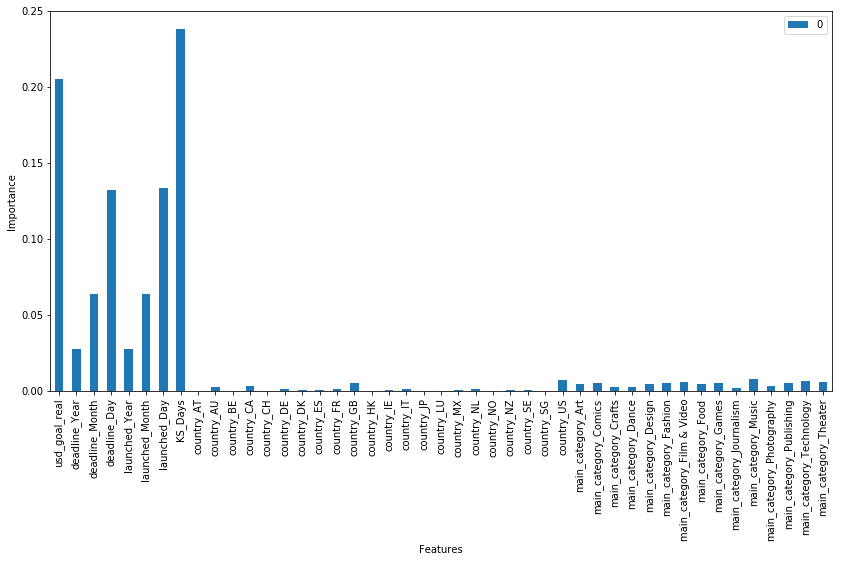

In [31]:
# 説明変数の重要度を出力する（feature_importances_はよく使う！！）
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
# 上位の不純度から、分けた際に不純度を下げた量の割合
print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_, index=X_data.columns).plot.bar(figsize=(14,7))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

## 3.3 ランダムフォレスト実行(グリッドサーチ)

In [32]:
test_size = 0.20        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) 
clf = RandomForestClassifier(verbose=True, n_jobs=-1, random_state=1234, n_estimators=100)
# clf = RandomForestClassifier(n_estimators=500,criterion="gini", min_samples_leaf=10, min_samples_split=5, random_state=1234)

search_params = {
    'max_features'      : [11, 12, 13],
    'n_estimators'      : [500],
    'random_state'      : [1234],
    'min_samples_split' : [65, 70, 75]
}
gs = GridSearchCV(RandomForestClassifier(),           # 対象の機械学習モデル
                  search_params,   # 探索パラメタ辞書
                  cv=3,            # クロスバリデーションの分割数
                  verbose=True,    # ログ表示
                  n_jobs=-1)
gs.fit(X_train, y_train)

print("score=", gs.score(X_train, y_train))

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 35.2min finished


score= 0.741550463556192


In [33]:
gs.best_params_

{'max_features': 12,
 'min_samples_split': 70,
 'n_estimators': 500,
 'random_state': 1234}

In [34]:
# 汎化誤差算出のため、テストデータに対する予測を実行
y_pred_test = gs.predict(X_test)

# 汎化誤差Precision, Recall, F1-scoreを計算
precision_test, recall_test, f1_score_test, _ = precision_recall_fscore_support(y_test, y_pred_test)

# 訓練誤差算出のため、トレーニングデータに対する予測を実行
y_pred_train = gs.predict(X_train)

# 訓練誤差Precision, Recall, F1-scoreを計算
precision_train, recall_train, f1_score_train, _ = precision_recall_fscore_support(y_train, y_pred_train)

df_model_performance.at[5,"model_name"] = 'ランダムフォレスト(グリッドサーチ)'
df_model_performance.at[5,"test_accuracy"] = accuracy_score(y_test,y_pred_test) * 100
df_model_performance.at[5,"test_precistion"] = precision_test[0] * 100
df_model_performance.at[5,"test_recall"] = recall_test[0] * 100
df_model_performance.at[5,"test_f1"] = f1_score_test[0] * 100
df_model_performance.at[5,"train_accuracy"] = accuracy_score(y_train,y_pred_train) * 100
df_model_performance.at[5,"train_precistion"] = precision_train[0] * 100
df_model_performance.at[5,"train_recall"] = recall_train[0] * 100
df_model_performance.at[5,"train_f1"] = f1_score_train[0] * 100

## 3.4 3.3で取得したグリッドサーチしたランダムフォレストとこれまでのモデルの精度を比較
※上述のなかでもっとも精度のよいモデルと比較した意
### →2%程度全体的に向上

In [35]:
df_model_performance

,model_name,test_accuracy,test_precistion,test_recall,test_f1,train_accuracy,train_precistion,train_recall,train_f1
0,Day1 logistic精度,52.483,76.339,29.404,42.456,NaN,NaN,NaN,NaN
1,Day2 logistic精度,64.698,67.246,79.537,72.865,NaN,NaN,NaN,NaN
2,logistic(特徴量選択前&L2正則化),64.0925,65.678,83.1736,73.3896,64.1285,65.7629,83.1501,73.4319
3,logistic(特徴量選択後&L2正則化),63.2253,64.6463,84.4034,73.2122,63.3037,64.7462,84.4533,73.2937
4,ランダムフォレスト,65.5295,68.9291,77.278,72.8651,99.9989,99.9981,100,99.9991
5,ランダムフォレスト(グリッドサーチ),68.0259,70.3898,80.4571,75.0875,74.155,74.7962,85.3568,79.7283
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 4. AdaBoost実施と評価
## 4.1 AdaBoost実施

In [36]:
test_size = 0.20        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) 
clf = AdaBoostClassifier(n_estimators=100)
search_params = {
    "base_estimator" : [DecisionTreeClassifier(max_depth=x)
                        for x in range(5, 10)],
    "learning_rate" : [0.5, 1.0, 1.5]
}
gs = GridSearchCV(clf,
                  search_params,   # 探索パラメタ辞書
                  cv=3,            # クロスバリデーションの分割数
                  verbose=True,    # ログ表示
                  n_jobs=-1)
gs.fit(X_train, y_train)

print("score=", gs.score(X_train, y_train))

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 36.4min finished


score= 0.6924474259440717


In [37]:
# 汎化誤差算出のため、テストデータに対する予測を実行
y_pred_test = gs.predict(X_test)

# 汎化誤差Precision, Recall, F1-scoreを計算
precision_test, recall_test, f1_score_test, _ = precision_recall_fscore_support(y_test, y_pred_test)

# 訓練誤差算出のため、トレーニングデータに対する予測を実行
y_pred_train = gs.predict(X_train)

# 訓練誤差Precision, Recall, F1-scoreを計算
precision_train, recall_train, f1_score_train, _ = precision_recall_fscore_support(y_train, y_pred_train)

df_model_performance.at[6,"model_name"] = 'AdaBoost'
df_model_performance.at[6,"test_accuracy"] = accuracy_score(y_test,y_pred_test) * 100
df_model_performance.at[6,"test_precistion"] = precision_test[0] * 100
df_model_performance.at[6,"test_recall"] = recall_test[0] * 100
df_model_performance.at[6,"test_f1"] = f1_score_test[0] * 100
df_model_performance.at[6,"train_accuracy"] = accuracy_score(y_train,y_pred_train) * 100
df_model_performance.at[6,"train_precistion"] = precision_train[0] * 100
df_model_performance.at[6,"train_recall"] = recall_train[0] * 100
df_model_performance.at[6,"train_f1"] = f1_score_train[0] * 100

In [38]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test,y_pred_test),
           index = ['正解：state_successful','正解：state_faild'],
           columns=['予測：state_successful','予測：state_faild'])

conf_mat

,予測：state_successful,予測：state_faild
正解：state_successful,31637,8091
正解：state_faild,13016,13591


## 4.2 4.1AdaBoostとこれまでのモデルを比較
⇒ランダムフォレスト（グリッドサーチ）と違いはほとんどなし

In [39]:
df_model_performance

,model_name,test_accuracy,test_precistion,test_recall,test_f1,train_accuracy,train_precistion,train_recall,train_f1
0,Day1 logistic精度,52.483,76.339,29.404,42.456,NaN,NaN,NaN,NaN
1,Day2 logistic精度,64.698,67.246,79.537,72.865,NaN,NaN,NaN,NaN
2,logistic(特徴量選択前&L2正則化),64.0925,65.678,83.1736,73.3896,64.1285,65.7629,83.1501,73.4319
3,logistic(特徴量選択後&L2正則化),63.2253,64.6463,84.4034,73.2122,63.3037,64.7462,84.4533,73.2937
4,ランダムフォレスト,65.5295,68.9291,77.278,72.8651,99.9989,99.9981,100,99.9991
5,ランダムフォレスト(グリッドサーチ),68.0259,70.3898,80.4571,75.0875,74.155,74.7962,85.3568,79.7283
6,AdaBoost,68.1812,70.8508,79.634,74.9861,69.2447,71.5202,80.3394,75.6737
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 5.ニューラルネット実施と評価
## 5.1 ニューラルネット実施

In [43]:
model = Sequential()
# ノード指定しているのは、テストケースだから（実務は違う）
# 最後のノードをsoftmaxにしてるのは、最後は確率で出したいから
# 最初のノードが6。活性化関数がrel。入力が４種類
model.add(Dense(10, activation='relu', input_dim=45))
model.add(Dense(10, activation='relu', input_dim=10))
model.add(Dense(10, activation='relu', input_dim=10))
model.add(Dense(10, activation='relu', input_dim=10))
model.add(Dense(2, activation='softmax'))#最終層のactivationは変更しないこと

# ------ 最適化手法 ------
# 実務上のはやりはAdam、RMSpropも人気
# sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
# rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
adam = Adam(lr=0.01)
# -----------------------------

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

# one-hotベクトルに変換
from tensorflow.keras.utils import to_categorical
y_NN_train = to_categorical(y_train)
y_NN_test = to_categorical(y_test)

Train on 265340 samples, validate on 66335 samples
Epoch 1/5
265340/265340 [==============================] - 13s 50us/sample - loss: 0.9220 - acc: 0.5949 - val_loss: 0.6754 - val_acc: 0.5989
Epoch 2/5
265340/265340 [==============================] - 14s 52us/sample - loss: 0.6754 - acc: 0.5954 - val_loss: 0.6744 - val_acc: 0.5989
Epoch 3/5
265340/265340 [==============================] - 15s 56us/sample - loss: 0.6753 - acc: 0.5954 - val_loss: 0.6741 - val_acc: 0.5989
Epoch 4/5
265340/265340 [==============================] - 15s 58us/sample - loss: 0.6753 - acc: 0.5954 - val_loss: 0.6739 - val_acc: 0.5989
Epoch 5/5
265340/265340 [==============================] - 16s 60us/sample - loss: 0.6753 - acc: 0.5954 - val_loss: 0.6773 - val_acc: 0.5989


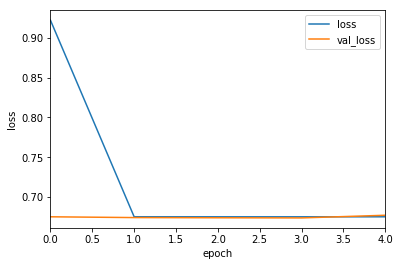

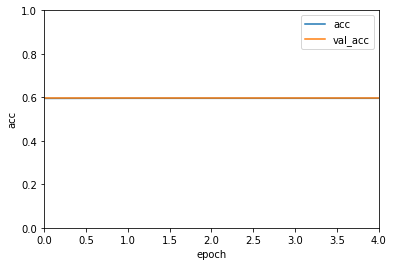

In [44]:
# 計算の実行
# batch_size：ランダムに20個ずつ取り出して、学習。ミニバッチ学習
# epochs：何回計算するか。100個データあったら、100個のデータを50回学習が以下の指定
fit = model.fit(X_train, y_NN_train,
          epochs=5,
          batch_size=20,validation_data=(X_test, y_NN_test))

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

# グラフ化：loss,acc⇒学習データの状況。val_loss,val_acc⇒ﾃｽﾄﾃﾞｰﾀの状況
# lossが低減しているのに、val_lossが上昇傾向だと過学習といえる
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

In [51]:
# 汎化誤差算出のため、テストデータに対する予測を実行
y_pred_test = np.argmax(model.predict(X_test),axis=1)

# 汎化誤差Precision, Recall, F1-scoreを計算
precision_test, recall_test, f1_score_test, _ = precision_recall_fscore_support(y_test, y_pred_test)

# 訓練誤差算出のため、トレーニングデータに対する予測を実行
y_pred_train = np.argmax(model.predict(X_train),axis=1)

# 訓練誤差Precision, Recall, F1-scoreを計算
precision_train, recall_train, f1_score_train, _ = precision_recall_fscore_support(y_train, y_pred_train)

df_model_performance.at[7,"model_name"] = 'NeuralNetworks'
df_model_performance.at[7,"test_accuracy"] = accuracy_score(y_test,y_pred_test) * 100
df_model_performance.at[7,"test_precistion"] = precision_test[0] * 100
df_model_performance.at[7,"test_recall"] = recall_test[0] * 100
df_model_performance.at[7,"test_f1"] = f1_score_test[0] * 100
df_model_performance.at[7,"train_accuracy"] = accuracy_score(y_train,y_pred_train) * 100
df_model_performance.at[7,"train_precistion"] = precision_train[0] * 100
df_model_performance.at[7,"train_recall"] = recall_train[0] * 100
df_model_performance.at[7,"train_f1"] = f1_score_train[0] * 100

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## 5.2 5.1NNとこれまでのモデルを比較
⇒すべてがPositiveと予測されてしまった・・・

In [52]:
df_model_performance

,model_name,test_accuracy,test_precistion,test_recall,test_f1,train_accuracy,train_precistion,train_recall,train_f1
0,Day1 logistic精度,52.483,76.339,29.404,42.456,NaN,NaN,NaN,NaN
1,Day2 logistic精度,64.698,67.246,79.537,72.865,NaN,NaN,NaN,NaN
2,logistic(特徴量選択前&L2正則化),64.0925,65.678,83.1736,73.3896,64.1285,65.7629,83.1501,73.4319
3,logistic(特徴量選択後&L2正則化),63.2253,64.6463,84.4034,73.2122,63.3037,64.7462,84.4533,73.2937
4,ランダムフォレスト,65.5295,68.9291,77.278,72.8651,99.9989,99.9981,100,99.9991
5,ランダムフォレスト(グリッドサーチ),68.0259,70.3898,80.4571,75.0875,74.155,74.7962,85.3568,79.7283
6,AdaBoost,68.1812,70.8508,79.634,74.9861,69.2447,71.5202,80.3394,75.6737
7,NeuralNetworks,59.89,59.89,100,74.914,59.5429,59.5429,100,74.6418
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test,y_pred_test),
           index = ['正解：state_successful','正解：state_faild'],
           columns=['予測：state_successful','予測：state_faild'])

conf_mat

,予測：state_successful,予測：state_faild
正解：state_successful,39728,0
正解：state_faild,26607,0


# 6.総括
ランダムフォレスト（グリッドサーチ）が一番精度が出た。NNについては、どこが問題なのか、確認が必要